# Emotion Detection with Deep Learning and Pretrained Transformers

This notebook builds an end-to-end emotion detector for the 2025 Sep DLGenAI Project competition.  
The workflow covers:

1. Dataset loading and exploratory analysis  
2. Text cleaning and multi-label target construction  
3. Three models from scratch (BiLSTM, BiLSTM + Attention, TextCNN)  
4. Two pretrained transformer models (DistilBERT, BERT)  
5. Weights and Biases tracking and Kaggle submissions

The goal is to compare different architectures using macro F1 and accuracy, and to document a clean, reproducible pipeline.


In [1]:
import kagglehub

path = kagglehub.competition_download("2025-sep-dl-gen-ai-project")
print("Local competition path:", path)


Local competition path: C:\Users\Gurur\.cache\kagglehub\competitions\2025-sep-dl-gen-ai-project


In [2]:
import os

os.chdir(r"C:\Users\Gurur\OneDrive\Desktop\PROJECTS\2025-Sep-DLGenAI-Project")
print("Now CWD =", os.getcwd())


Now CWD = C:\Users\Gurur\OneDrive\Desktop\PROJECTS\2025-Sep-DLGenAI-Project


In [3]:
import os
import pandas as pd
import kagglehub

COMP_SLUG = "2025-sep-dl-gen-ai-project"

def get_competition_dir(slug=COMP_SLUG):
    kaggle_input_root = f"/kaggle/input/{slug}"
    if os.path.exists(kaggle_input_root):
        print("Detected Kaggle environment, using:", kaggle_input_root)
        return kaggle_input_root

    print("Running locally, downloading via Kaggle Hub...")
    comp_dir = kagglehub.competition_download(slug)
    print("Local competition dir:", comp_dir)
    return comp_dir

comp_dir = get_competition_dir()

train = pd.read_csv(os.path.join(comp_dir, "train.csv"))
test = pd.read_csv(os.path.join(comp_dir, "test.csv"))
sample_submission = pd.read_csv(os.path.join(comp_dir, "sample_submission.csv"))

print(train.shape, test.shape, sample_submission.shape)


Running locally, downloading via Kaggle Hub...
Local competition dir: C:\Users\Gurur\.cache\kagglehub\competitions\2025-sep-dl-gen-ai-project
(6827, 8) (1707, 2) (1707, 6)


In [5]:
import wandb

wandb.login()

wandb: Currently logged in as: 22f3000400 (DL-Genai-Project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
WANDB_ENTITY = "DL-Genai-Project"       
WANDB_PROJECT = "22f3000400-t32025"    

run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    name="smoketest-no-model",
    config={"purpose": "env_check"}
)

wandb.log({"dummy_metric": 1.0})

run.finish()


dummy_metric,▁
dummy_metric,1


In [7]:
# train = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/train.csv")
# test = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/test.csv")
# sample_sub = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (6827, 8)
Test shape: (1707, 2)


,id,text,anger,fear,joy,sadness,surprise,emotions
0,0,the dentist that did the work apparently did a...,1,0,0,1,0,['anger' 'sadness']
1,1,i'm gonna absolutely ~~suck~~ be terrible duri...,0,1,0,1,0,['fear' 'sadness']
2,2,"bridge: so leave me drowning calling houston, ...",0,1,0,1,0,['fear' 'sadness']
3,3,after that mess i went to see my now ex-girlfr...,1,1,0,1,0,['anger' 'fear' 'sadness']
4,4,"as he stumbled i ran off, afraid it might some...",0,1,0,0,0,['fear']


In [8]:
label_cols = ["anger", "fear", "joy", "sadness", "surprise"]

# Data Cleaning and EDA

## 1. Exploratory Data Analysis

Before training any model, we inspect the dataset to understand:

- Typical text length and word count  
- How many emotions are attached to a single sentence  
- Label balance and co-occurrence patterns  

These insights guide hyperparameters such as maximum sequence length and highlight potential class imbalance issues.


In [7]:
print(train.isnull().sum())

id          0
text        0
anger       0
fear        0
joy         0
sadness     0
surprise    0
emotions    0
dtype: int64


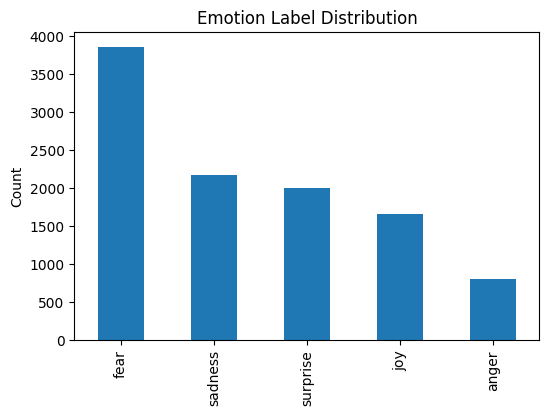

In [116]:
#Label distribution
import matplotlib.pyplot as plt
import seaborn as sns
train[label_cols].sum().sort_values(ascending=False).plot(kind='bar', figsize=(6,4))
plt.title("Emotion Label Distribution")
plt.ylabel("Count")
plt.show()

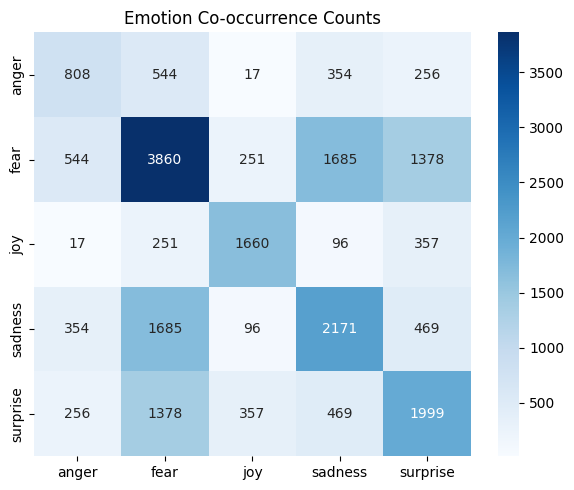

In [118]:
#Emotion co-occurrence heatmap

label_cols = [c for c in ["anger","fear","joy","sadness","surprise"] if c in train.columns]

cooc = train[label_cols].T @ train[label_cols]
plt.figure(figsize=(6,5))
sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues")
plt.title("Emotion Co-occurrence Counts")
plt.tight_layout()


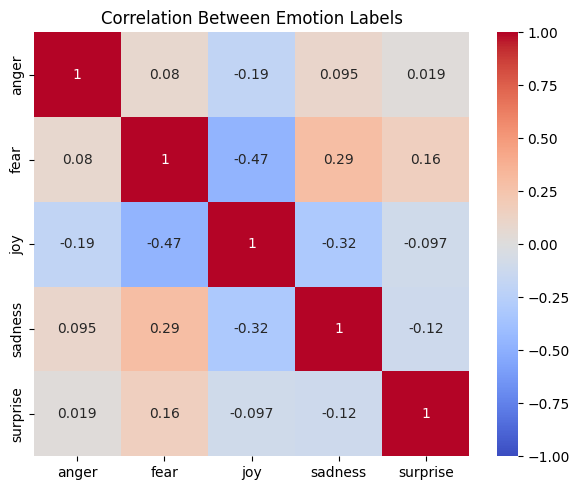

In [120]:
#Correlation between emotion labels

corr = train[label_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Correlation Between Emotion Labels")
plt.tight_layout()


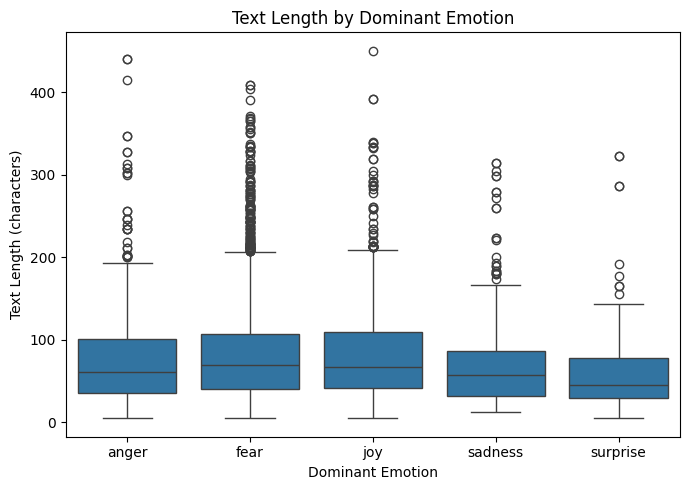

In [123]:
# Text length by dominant emotion (boxplot)

TEXT_COL = "clean_text" if "clean_text" in train.columns else "text"
if "text_len" not in train.columns:
    train["text_len"] = train[TEXT_COL].astype(str).str.len()

has_any = train[label_cols].sum(axis=1) > 0
dom_emotion = train.loc[has_any, label_cols].idxmax(axis=1)
tmp = train.loc[has_any].copy()
tmp["dominant_emotion"] = dom_emotion

plt.figure(figsize=(7,5))
sns.boxplot(data=tmp, x="dominant_emotion", y="text_len")
plt.xlabel("Dominant Emotion")
plt.ylabel("Text Length (characters)")
plt.title("Text Length by Dominant Emotion")
plt.tight_layout()


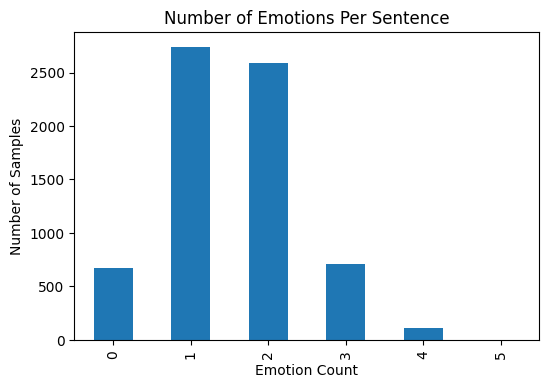

In [9]:
#Number of emotions per text
train["num_emotions"] = train[label_cols].sum(axis=1)

train["num_emotions"].value_counts().sort_index().plot(kind='bar', figsize=(6,4))
plt.title("Number of Emotions Per Sentence")
plt.xlabel("Emotion Count")
plt.ylabel("Number of Samples")
plt.show()

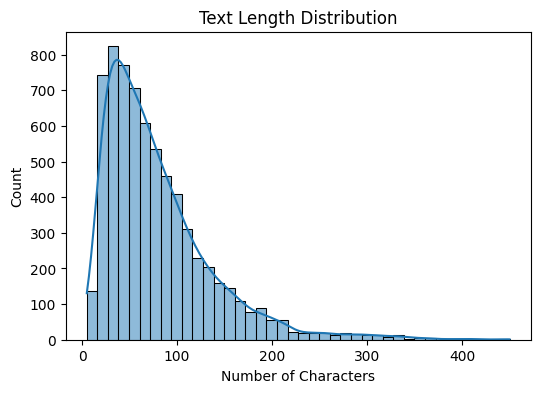

Average text length: 79.43078951223085
Max length: 450
Min length: 5


In [10]:
#Text length distribution
train["text_len"] = train["text"].astype(str).apply(len)

plt.figure(figsize=(6,4))
sns.histplot(train["text_len"], bins=40, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Number of Characters")
plt.show()

print("Average text length:", train["text_len"].mean())
print("Max length:", train["text_len"].max())
print("Min length:", train["text_len"].min())


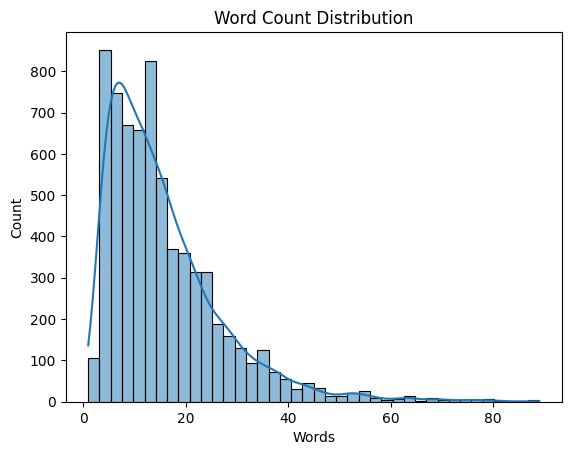

Average words: 15.684781016551927


In [11]:
#Word count distribution
train["word_count"] = train["text"].apply(lambda x: len(str(x).split()))

sns.histplot(train["word_count"], bins=40, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Words")
plt.show()

print("Average words:", train["word_count"].mean())

In [12]:
#duplicates
print("Duplicate texts:", train.duplicated("text").sum())


Duplicate texts: 1841


In [13]:
#noisy examples
noisy_examples = train[train["text"].str.contains("[^a-zA-Z0-9.,!?/' ]")]["text"].head(10)
print("Noisy text samples:\n")
for t in noisy_examples:
    print("-", t)

Noisy text samples:

- i'm gonna absolutely ~~suck~~ be terrible during my first sexual experience ._.
- bridge: so leave me drowning calling houston, and let my lungs cave in, from calling god, for my mistakes and to the one who deserves the apology.
- after that mess i went to see my now ex-girlfriend at school because she refused to drive home to see me.
- " and burst into tears.
- first me, a slight stir from my legs, a stretching of my toes, and immediately following my father says, `` hmm? ''
- the song `` poor places '' is ironically seeping out of my speakers and into my ears: it's hot in the poor places tonight / i'm not going outside
- so i was like "wtf, you have the bag, read the bag.
- `` i felt my eyelids swelling shut and the crack in my collarbone started to throb.
- i never saw that thing again, because evidently it was "stolen".
- "  i'm like "sure.


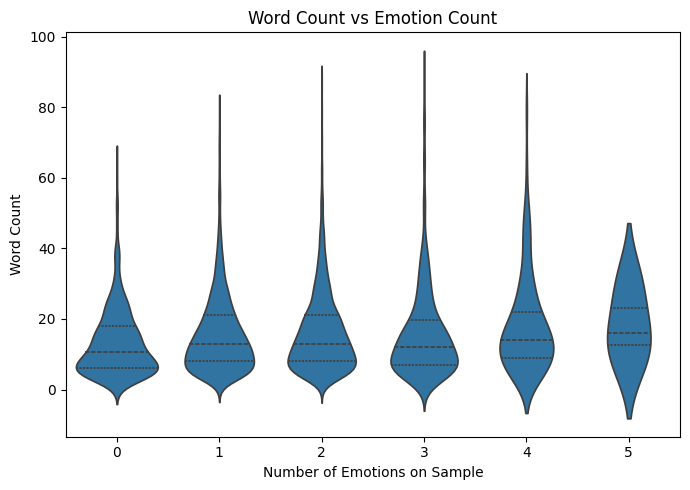

In [124]:
# Word count vs number of emotions (violin / boxplot)

if "word_count" not in train.columns:
    train["word_count"] = train[TEXT_COL].astype(str).str.split().str.len()

train["emotion_count"] = train[label_cols].sum(axis=1).astype(int)

plt.figure(figsize=(7,5))
sns.violinplot(data=train, x="emotion_count", y="word_count", inner="quartile")
plt.xlabel("Number of Emotions on Sample")
plt.ylabel("Word Count")
plt.title("Word Count vs Emotion Count")
plt.tight_layout()


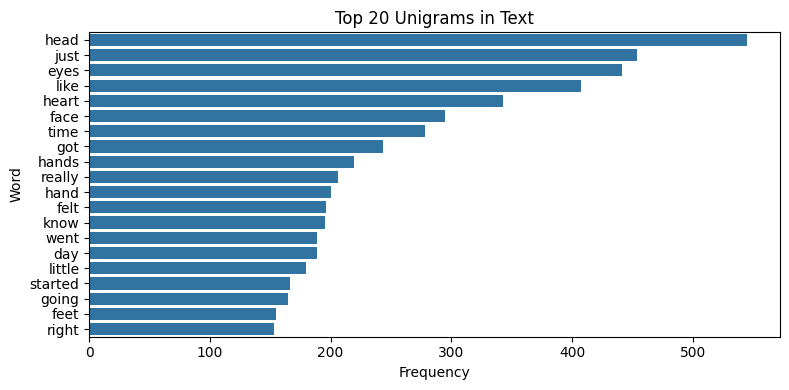

In [126]:
# Top 20 unigrams in the dataset

from sklearn.feature_extraction.text import CountVectorizer

corpus = train[TEXT_COL].astype(str).tolist()
vec = CountVectorizer(max_features=2000, stop_words="english")
X = vec.fit_transform(corpus)
word_counts = np.asarray(X.sum(axis=0)).ravel()
vocab = np.array(vec.get_feature_names_out())

top_idx = word_counts.argsort()[::-1][:20]
top_words = vocab[top_idx]
top_vals = word_counts[top_idx]

plt.figure(figsize=(8,4))
sns.barplot(x=top_vals, y=top_words, orient="h")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 20 Unigrams in Text")
plt.tight_layout()


## 2. Preprocessing and Label Construction

The competition uses a multi-label setup where each sentence can express several emotions.  
In this section we:

- Normalize raw text into a `clean_text` column  
- Convert the `emotions` field into five binary columns  
- Add helper features (length, word count) for analysis only  

The same label format is reused across all models to keep comparisons fair.


In [14]:
import re
import html

def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = html.unescape(text)
    text = text.encode("ascii", "ignore").decode()
    text = re.sub(r"\s+", " ", text).strip()
    return text
    
train["clean_text"] = train["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)

In [15]:
# # Basic cleaning 
train['text'] = train['text'].astype(str).fillna("")
test['text'] = test['text'].astype(str).fillna("")

In [16]:
# #Utilise the TfidfVectorizer to tokenize the text feature dataset, setting the following parameters: ngram_range=(1, 2) and stop_words=‘english’.
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(train['text'])

# Insights on Data

In [17]:
# #What is the dimension of your feature matrix?
X.shape

(6827, 33896)

In [18]:
# #Is this feature representation sparse or dense?
from scipy import sparse
print(sparse.issparse(X))

True


In [19]:
# #Which emotion is the most common in the given dataset?
emotion = train[label_cols].sum().sort_values(ascending=False)

print("\nMost common emotion:", emotion.idxmax())
print("Count:", emotion.max())


Most common emotion: fear
Count: 3860


In [20]:
# #What is the total count of such instances in the training set that have exactly 2 labels?
train["label_sum"] = train[label_cols].sum(axis=1)
labels = (train["label_sum"] == 2).sum()

print("\nRows with exactly 2 labels:", labels)


Rows with exactly 2 labels: 2587


In [21]:
# #What is the number of rows where 'Joy' and 'Sadness' occur together in the training set?
row = ((train["joy"] == 1) & (train["sadness"] == 1)).sum()

print("\nJoy & Sadness:", row)


Joy & Sadness: 96


In [22]:
# #What is the percentage of the dataset containing 'Surprise'?
surprise = 100 * (train["surprise"].sum() / len(train))

print(f"Percentage: {surprise:.2f}%")

Percentage: 29.28%


In [23]:
# #What is the maximum difference in occurrence counts between any two emotion labels?
diff = emotion.max() - emotion.min()

print("\nMaximum difference:", diff)


Maximum difference: 3052


In [24]:
# #What is the median word length of the texts?
train["word_count"] = train["text"].astype(str).apply(lambda x: len(x.split()))
median = train["word_count"].median()

print("\nMedian:", median)


Median: 13.0


In [25]:
# #What is the correlation coefficient value between anger and fear? Round to 2 decimal places.
corr = round(train["anger"].corr(train["fear"]), 2)

print("\nCorrelation:", corr)


Correlation: 0.08


In [26]:
# #Convert all text to lowercase for normalization. Remove all special characters from the dataset using string.punctuation
import string
train["text_clean"] = train["text"].astype(str).str.lower()

def remove(text):
    return text.translate(str.maketrans("", "", string.punctuation))

train["text_clean"] = train["text_clean"].apply(remove)

In [27]:
# #What is the percentage reduction in total character count after removing punctuation?
original = train["text"].astype(str).apply(len).sum()
clean = train["text_clean"].astype(str).apply(len).sum()
reduction = 100 * (original - clean) / original

print(f"\nPercentage reduction: {reduction:.2f}%")



Percentage reduction: 3.26%


In [28]:
# # Basic cleaning 
train['text'] = train['text'].astype(str).fillna("")
test['text'] = test['text'].astype(str).fillna("")

# Model Training

## 3. Common Utilities

To avoid repeating code, we define reusable components.
Every model section reuses these utilities with only the architecture changed.

In [46]:
from sklearn.model_selection import train_test_split
import numpy as np

label_cols = ["anger", "fear", "joy", "sadness", "surprise"]

TEXT_COL = "clean_text" if "clean_text" in train.columns else "text"
print("Using text column:", TEXT_COL)

for col in label_cols:
    train[col] = train[col].astype("float32")

train_df, val_df = train_test_split(
    train,
    test_size=0.1,
    random_state=42,
    stratify=train[label_cols].values.argmax(axis=1),  # rough stratification
)

print("Train size:", train_df.shape[0], "Val size:", val_df.shape[0])

train_texts = train_df[TEXT_COL].astype(str).tolist()
val_texts = val_df[TEXT_COL].astype(str).tolist()
test_texts = test[TEXT_COL if TEXT_COL in test.columns else "text"].astype(str).tolist()

y_train = train_df[label_cols].values.astype("float32")
y_val = val_df[label_cols].values.astype("float32")

print("y_train shape:", y_train.shape, "y_val shape:", y_val.shape)


Using text column: clean_text
Train size: 6144 Val size: 683
y_train shape: (6144, 5) y_val shape: (683, 5)


In [47]:
from collections import Counter

MAX_VOCAB_SIZE = 20000
MAX_LEN = 80  

counter = Counter()
for text in train_texts:
    counter.update(text.split())

most_common = counter.most_common(MAX_VOCAB_SIZE - 2)

stoi = {"<pad>": 0, "<unk>": 1}
for idx, (word, _) in enumerate(most_common, start=2):
    stoi[word] = idx

vocab_size = len(stoi)
print("Vocab size:", vocab_size)

def encode_text(text, stoi_dict, max_len):
    tokens = text.split()
    ids = [stoi_dict.get(tok, 1) for tok in tokens][:max_len]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    return ids

X_train_ids = np.array([encode_text(t, stoi, MAX_LEN) for t in train_texts], dtype="int64")
X_val_ids = np.array([encode_text(t, stoi, MAX_LEN) for t in val_texts], dtype="int64")
X_test_ids = np.array([encode_text(t, stoi, MAX_LEN) for t in test_texts], dtype="int64")

print("Train IDs:", X_train_ids.shape, "Val IDs:", X_val_ids.shape, "Test IDs:", X_test_ids.shape)


Vocab size: 11181
Train IDs: (6144, 80) Val IDs: (683, 80) Test IDs: (1707, 80)


# Model 1 – BiLSTM Baseline (from scratch)

The first model is a simple BiLSTM encoder over word indices:

- Randomly initialised embedding layer  
- Bidirectional LSTM  
- Concatenated final hidden states fed into a linear classifier  

This acts as a strong and interpretable baseline for the remaining models.


In [48]:
import torch
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

class LSTMDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = None
        if y is not None:
            self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64

train_dataset_lstm = LSTMDataset(X_train_ids, y_train)
val_dataset_lstm = LSTMDataset(X_val_ids, y_val)
test_dataset_lstm = LSTMDataset(X_test_ids, None)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=BATCH_SIZE, shuffle=False)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader_lstm), len(val_loader_lstm), len(test_loader_lstm)


Device: cpu


(96, 11, 27)

In [49]:
from torch import nn

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        output, (h_n, c_n) = self.lstm(x)
        h_forward = h_n[-2]
        h_backward = h_n[-1]
        h_cat = torch.cat((h_forward, h_backward), dim=1)
        x = self.dropout(h_cat)
        logits = self.fc(x)
        return logits

EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_LABELS = len(label_cols)

model1 = BiLSTMModel(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LABELS).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

model1


BiLSTMModel(
  (embedding): Embedding(11181, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [50]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate_lstm(model, dataloader, device, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    return macro_f1, acc


In [51]:
EPOCHS = 10 

run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    name="model1_bilstm_scratch",
    config={
        "model": "BiLSTM_scratch",
        "max_vocab_size": MAX_VOCAB_SIZE,
        "max_len": MAX_LEN,
        "embed_dim": EMBED_DIM,
        "hidden_dim": HIDDEN_DIM,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "lr": 1e-3,
    },
)

best_val_f1 = 0.0
best_state_dict = None

for epoch in range(EPOCHS):
    model1.train()
    running_loss = 0.0

    for inputs, labels in train_loader_lstm:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model1(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader_lstm.dataset)
    val_f1, val_acc = evaluate_lstm(model1, val_loader_lstm, DEVICE)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state_dict = model1.state_dict()

    wandb.log(
        {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_macro_f1": val_f1,
            "val_accuracy": val_acc,
        }
    )

    print(
        f"Epoch {epoch + 1}/{EPOCHS} - loss: {train_loss:.4f} - val_f1: {val_f1:.4f} - val_acc: {val_acc:.4f}"
    )

if best_state_dict is not None:
    model1.load_state_dict(best_state_dict)

print("Best validation macro F1:", best_val_f1)

run.finish()


Epoch 1/10 - loss: 0.5747 - val_f1: 0.1432 - val_acc: 0.1611
Epoch 2/10 - loss: 0.5420 - val_f1: 0.2039 - val_acc: 0.1772
Epoch 3/10 - loss: 0.5098 - val_f1: 0.3373 - val_acc: 0.2387
Epoch 4/10 - loss: 0.4533 - val_f1: 0.4214 - val_acc: 0.2899
Epoch 5/10 - loss: 0.3931 - val_f1: 0.4717 - val_acc: 0.3163
Epoch 6/10 - loss: 0.3248 - val_f1: 0.5270 - val_acc: 0.3675
Epoch 7/10 - loss: 0.2644 - val_f1: 0.5710 - val_acc: 0.4217
Epoch 8/10 - loss: 0.2138 - val_f1: 0.6013 - val_acc: 0.4612
Epoch 9/10 - loss: 0.1717 - val_f1: 0.6439 - val_acc: 0.4993
Epoch 10/10 - loss: 0.1398 - val_f1: 0.6645 - val_acc: 0.5198
Best validation macro F1: 0.6644987762790899


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▅▄▃▂▂▁
val_accuracy,▁▁▃▄▄▅▆▇██
val_macro_f1,▁▂▄▅▅▆▇▇██
epoch,10
train_loss,0.13976
val_accuracy,0.51977
val_macro_f1,0.6645


In [53]:
from pathlib import Path

ROOT = Path.cwd()
ARTIFACT_DIR = ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

MODEL1_PATH = ARTIFACT_DIR / "model1_bilstm_scratch.pt"
submission_path = ARTIFACT_DIR / "submission_model1_bilstm.csv"
torch.save(
    {
        "model_state_dict": model1.state_dict(),
        "stoi": stoi,
        "max_len": MAX_LEN,
        "embed_dim": EMBED_DIM,
        "hidden_dim": HIDDEN_DIM,
        "label_cols": label_cols,
        "vocab_size": vocab_size,
    },
    MODEL1_PATH,
)
print("Saved checkpoint to:", MODEL1_PATH)


Saved checkpoint to: C:\Users\Gurur\OneDrive\Desktop\PROJECTS\2025-Sep-DLGenAI-Project\artifacts\model1_bilstm_scratch.pt


In [54]:
model1.eval()
all_test_preds = []

with torch.no_grad():
    for inputs in test_loader_lstm:
        inputs = inputs.to(DEVICE)
        logits = model1(inputs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().cpu().numpy()
        all_test_preds.append(preds)

all_test_preds = np.vstack(all_test_preds)

submission_model1 = pd.DataFrame(all_test_preds, columns=label_cols)
submission_model1.insert(0, "id", test["id"])

submission_model1.head() 
submission_model1.to_csv(submission_path, index=False)
print("Saved submission to:", submission_path)

Saved submission to: C:\Users\Gurur\OneDrive\Desktop\PROJECTS\2025-Sep-DLGenAI-Project\artifacts\submission_model1_bilstm.csv


# Model-2 (BiLSTM + Attention)

Model 2 extends the baseline with a trainable attention layer over all time steps:

- BiLSTM encodes the sequence  
- Attention weights focus on informative tokens  
- Weighted sum of hidden states is classified into emotions  

This variant tests whether explicit token-level weighting improves performance over simple pooling.

In [74]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from collections import Counter
from pathlib import Path
import wandb

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEXT_COL = "clean_text" if "clean_text" in train.columns else "text"
label_cols2 = [c for c in train.columns if c not in ["id", "text", "clean_text"] and train[c].dtype != object]

MAX_LEN2 = 80
EMBED_DIM2 = 128
HIDDEN_DIM2 = 128
BATCH_SIZE2 = 64
EPOCHS2 = 12
LR2 = 1e-3


In [75]:
counter2 = Counter()
for t in train[TEXT_COL].astype(str):
    counter2.update(t.split())

stoi2 = {"<pad>": 0, "<unk>": 1}
for w in counter2.keys():
    if w not in stoi2:
        stoi2[w] = len(stoi2)

vocab_size2 = len(stoi2)

def encode_text2(text):
    tokens = str(text).split()
    ids = [stoi2.get(tok, 1) for tok in tokens][:MAX_LEN2]
    if len(ids) < MAX_LEN2:
        ids += [0] * (MAX_LEN2 - len(ids))
    return ids


In [76]:
class TextDataset2(Dataset):
    def __init__(self, texts, labels=None):
        x = [encode_text2(t) for t in texts]
        self.X = torch.tensor(np.array(x, dtype="int64"), dtype=torch.long)
        self.y = None if labels is None else torch.tensor(labels.astype("float32"), dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

X_all2 = train[TEXT_COL].astype(str).values
y_all2 = train[label_cols2].values

X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_all2, y_all2, test_size=0.15, random_state=42
)

train_ds2 = TextDataset2(X_train2, y_train2)
val_ds2 = TextDataset2(X_val2, y_val2)

train_loader2 = DataLoader(train_ds2, batch_size=BATCH_SIZE2, shuffle=True)
val_loader2 = DataLoader(val_ds2, batch_size=BATCH_SIZE2, shuffle=False)


In [77]:
class BiLSTMAttn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
    def forward(self, x):
        x = self.embedding(x)
        outputs, (h, c) = self.lstm(x)
        u = torch.tanh(self.attn(outputs))
        scores = self.v(u).squeeze(-1)
        alpha = torch.softmax(scores, dim=1).unsqueeze(-1)
        context = torch.sum(alpha * outputs, dim=1)
        context = self.dropout(context)
        logits = self.fc(context)
        return logits


In [78]:
def train_epoch2(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch2(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.append(preds)
            all_targets.append(y_batch.cpu().numpy())
    y_true = np.vstack(all_targets)
    y_pred = np.vstack(all_preds)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    return total_loss / len(loader.dataset), macro_f1, acc


In [79]:
wandb_config2 = {
    "model": "BiLSTM_Attention",
    "max_len": MAX_LEN2,
    "vocab_size": vocab_size2,
    "embed_dim": EMBED_DIM2,
    "hidden_dim": HIDDEN_DIM2,
    "batch_size": BATCH_SIZE2,
    "epochs": EPOCHS2,
    "lr": LR2,
    "labels": label_cols2,
}

wandb.init(
    project="22f3000400-t32025",
    name="model2_bilstm_attention",
    config=wandb_config2,
)

model2 = BiLSTMAttn(vocab_size2, EMBED_DIM2, HIDDEN_DIM2, len(label_cols2)).to(DEVICE)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=LR2)
criterion2 = nn.BCEWithLogitsLoss()

best_f1_2 = 0.0
best_state_2 = None

for epoch in range(1, EPOCHS2 + 1):
    train_loss_2 = train_epoch2(model2, train_loader2, optimizer2, criterion2)
    val_loss_2, val_f1_2, val_acc_2 = eval_epoch2(model2, val_loader2, criterion2)
    if val_f_2 := val_f1_2 > best_f1_2:
        best_f1_2 = val_f1_2
        best_state_2 = model2.state_dict()
    wandb.log(
        {
            "epoch": epoch,
            "model2_train_loss": train_loss_2,
            "model2_val_loss": val_loss_2,
            "model2_val_macro_f1": val_f1_2,
            "model2_val_accuracy": val_acc_2,
        }
    )
    print(epoch, train_loss_2, val_loss_2, val_f1_2, val_acc_2)

wandb.finish()

if best_state_2 is not None:
    model2.load_state_dict(best_state_2)


1 0.5738882980277644 0.5484918563540389 0.2151592444141675 0.14536585365853658
2 0.5420199838517987 0.5368322137506997 0.2865901345514607 0.1873170731707317
3 0.5003360474121977 0.5032570358020504 0.3680824267534144 0.24878048780487805
4 0.42906515555560937 0.4821953672316016 0.42990500113176566 0.2917073170731707
5 0.35170218152286514 0.47387382600365613 0.5052410749012922 0.3404878048780488
6 0.2833615483466365 0.46077884595568586 0.5806921660682302 0.38439024390243903
7 0.2263235714580634 0.4733654722353307 0.6329413272306116 0.4321951219512195
8 0.17640268749222596 0.4954102179480762 0.6351821616464288 0.4653658536585366
9 0.14157898798559254 0.4882230159276869 0.6659795417634784 0.48585365853658535
10 0.11036995264660773 0.5238704615685998 0.690959677579006 0.5248780487804878
11 0.08459937417355129 0.5332740989254742 0.7020590888045477 0.5521951219512196
12 0.06712168031871339 0.5513082913654607 0.7045940094665337 0.5551219512195122


epoch,▁▂▂▃▄▄▅▅▆▇▇█
model2_train_loss,██▇▆▅▄▃▃▂▂▁▁
model2_val_accuracy,▁▂▃▃▄▅▆▆▇▇██
model2_val_loss,█▇▄▃▂▁▂▄▃▆▇█
model2_val_macro_f1,▁▂▃▄▅▆▇▇▇███
epoch,12
model2_train_loss,0.06712
model2_val_accuracy,0.55512
model2_val_loss,0.55131
model2_val_macro_f1,0.70459


In [80]:
ROOT = Path.cwd()
ARTIFACT_DIR = ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

MODEL2_PATH = ARTIFACT_DIR / "model2_bilstm_attention.pt"

torch.save(
    {
        "model_state_dict": model2.state_dict(),
        "stoi": stoi2,
        "max_len": MAX_LEN2,
        "embed_dim": EMBED_DIM2,
        "hidden_dim": HIDDEN_DIM2,
        "label_cols": label_cols2,
        "vocab_size": vocab_size2,
    },
    MODEL2_PATH,
)

test_texts2 = test[TEXT_COL].astype(str).values
X_test2 = np.array([encode_text2(t) for t in test_texts2], dtype="int64")
test_ds2 = TextDataset2(test_texts2)
test_ds2.X = torch.tensor(X_test2, dtype=torch.long)
test_loader2 = DataLoader(test_ds2, batch_size=BATCH_SIZE2, shuffle=False)

model2.eval()
all_preds2 = []
with torch.no_grad():
    for X_batch in test_loader2:
        X_batch = X_batch.to(DEVICE)
        logits = model2(X_batch)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds2.append(preds)

all_preds2 = np.vstack(all_preds2)

submission2 = pd.DataFrame(all_preds2, columns=label_cols2)
submission2.insert(0, "id", test["id"])
submission2_path = ARTIFACT_DIR / "submission_model2_bilstm_attention.csv"
submission2.to_csv(submission2_path, index=False)
submission2.head()


,id,anger,fear,joy,sadness,surprise
0,0,1,1,0,0,0
1,1,0,0,0,0,0
2,2,1,1,0,0,0
3,3,0,1,0,0,0
4,4,0,1,0,0,1


# Model-3 TextCNN

TextCNN provides a convolutional alternative:

- Multiple convolution filters capture n-gram patterns  
- Max pooling over time per filter  
- Concatenated feature vector fed to a classifier  

This helps compare recurrent versus convolutional encoders on the same task.

In [88]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from collections import Counter
from pathlib import Path
import wandb

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEXT_COL = "clean_text" if "clean_text" in train.columns else "text"
label_cols3 = [c for c in train.columns if c not in ["id", "text", "clean_text"] and train[c].dtype != object]

MAX_LEN3 = 80
EMBED_DIM3 = 128
BATCH_SIZE3 = 64
EPOCHS3 = 12
LR3 = 1e-3
NUM_FILTERS3 = 128
FILTER_SIZES3 = [3, 4, 5]


In [89]:
counter3 = Counter()
for t in train[TEXT_COL].astype(str):
    counter3.update(t.split())

stoi3 = {"<pad>": 0, "<unk>": 1}
for w in counter3.keys():
    if w not in stoi3:
        stoi3[w] = len(stoi3)

vocab_size3 = len(stoi3)

def encode_text3(text):
    tokens = str(text).split()
    ids = [stoi3.get(tok, 1) for tok in tokens][:MAX_LEN3]
    if len(ids) < MAX_LEN3:
        ids += [0] * (MAX_LEN3 - len(ids))
    return ids


In [90]:
class TextDataset3(Dataset):
    def __init__(self, texts, labels=None):
        x = [encode_text3(t) for t in texts]
        self.X = torch.tensor(np.array(x, dtype="int64"), dtype=torch.long)
        self.y = None if labels is None else torch.tensor(labels.astype("float32"), dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

X_all3 = train[TEXT_COL].astype(str).values
y_all3 = train[label_cols3].values

X_train3, X_val3, y_train3, y_val3 = train_test_split(
    X_all3, y_all3, test_size=0.15, random_state=42
)

train_ds3 = TextDataset3(X_train3, y_train3)
val_ds3 = TextDataset3(X_val3, y_val3)

train_loader3 = DataLoader(train_ds3, batch_size=BATCH_SIZE3, shuffle=True)
val_loader3 = DataLoader(val_ds3, batch_size=BATCH_SIZE3, shuffle=False)


In [91]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList(
            [nn.Conv1d(embed_dim, num_filters, kernel_size=k) for k in filter_sizes]
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_labels)
    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        xs = []
        for conv in self.convs:
            h = torch.relu(conv(x))
            h = torch.max(h, dim=2).values
            xs.append(h)
        x = torch.cat(xs, dim=1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits


In [92]:
def train_epoch3(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch3(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.append(preds)
            all_targets.append(y_batch.cpu().numpy())
    y_true = np.vstack(all_targets)
    y_pred = np.vstack(all_preds)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    return total_loss / len(loader.dataset), macro_f1, acc


In [93]:
wandb_config3 = {
    "model": "TextCNN",
    "max_len": MAX_LEN3,
    "vocab_size": vocab_size3,
    "embed_dim": EMBED_DIM3,
    "num_filters": NUM_FILTERS3,
    "filter_sizes": FILTER_SIZES3,
    "batch_size": BATCH_SIZE3,
    "epochs": EPOCHS3,
    "lr": LR3,
    "labels": label_cols3,
}

wandb.init(
    project="22f3000400-t32025",
    name="model3_textcnn",
    config=wandb_config3,
)

model3 = TextCNN(vocab_size3, EMBED_DIM3, NUM_FILTERS3, FILTER_SIZES3, len(label_cols3)).to(DEVICE)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=LR3)
criterion3 = nn.BCEWithLogitsLoss()

best_f1_3 = 0.0
best_state_3 = None

for epoch in range(1, EPOCHS3 + 1):
    train_loss_3 = train_epoch3(model3, train_loader3, optimizer3, criterion3)
    val_loss_3, val_f1_3, val_acc_3 = eval_epoch3(model3, val_loader3, criterion3)
    if val_f1_3 > best_f1_3:
        best_f1_3 = val_f1_3
        best_state_3 = model3.state_dict()
    wandb.log(
        {
            "epoch": epoch,
            "model3_train_loss": train_loss_3,
            "model3_val_loss": val_loss_3,
            "model3_val_macro_f1": val_f1_3,
            "model3_val_accuracy": val_acc_3,
        }
    )
    print(epoch, train_loss_3, val_loss_3, val_f1_3, val_acc_3)

wandb.finish()

if best_state_3 is not None:
    model3.load_state_dict(best_state_3)


1 0.5816894502567448 0.5229916901704742 0.2265641913691574 0.16878048780487806
2 0.5083877217025848 0.4968673802003628 0.2729663256296508 0.20780487804878048
3 0.4541091074700275 0.4663546650584151 0.3559050411637951 0.25951219512195123
4 0.4013891570303449 0.43865189941917976 0.48917660884781516 0.36878048780487804
5 0.35402853096077996 0.41538062368951195 0.5139985055356817 0.3931707317073171
6 0.3059440671637403 0.40748518682107693 0.5550755193994943 0.4253658536585366
7 0.27139731990966415 0.3821421200327757 0.6410306986149708 0.4926829268292683
8 0.2337482863512585 0.3712536972034268 0.6792842419987363 0.5395121951219513
9 0.20658672891970709 0.3699810073724607 0.6990554253062815 0.5570731707317074
10 0.18028709453699795 0.37341946843193796 0.696383782218436 0.5609756097560976
11 0.15406462860925163 0.3691810004304095 0.7150448528746302 0.5814634146341463
12 0.13956026836680116 0.37474890478500505 0.7205011206464829 0.584390243902439


epoch,▁▂▂▃▄▄▅▅▆▇▇█
model3_train_loss,█▇▆▅▄▄▃▂▂▂▁▁
model3_val_accuracy,▁▂▃▄▅▅▆▇████
model3_val_loss,█▇▅▄▃▃▂▁▁▁▁▁
model3_val_macro_f1,▁▂▃▅▅▆▇▇████
epoch,12
model3_train_loss,0.13956
model3_val_accuracy,0.58439
model3_val_loss,0.37475
model3_val_macro_f1,0.7205


In [94]:
ARTIFACT_DIR = Path.cwd() / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

MODEL3_PATH = ARTIFACT_DIR / "model3_textcnn.pt"

torch.save(
    {
        "model_state_dict": model3.state_dict(),
        "stoi": stoi3,
        "max_len": MAX_LEN3,
        "embed_dim": EMBED_DIM3,
        "num_filters": NUM_FILTERS3,
        "filter_sizes": FILTER_SIZES3,
        "label_cols": label_cols3,
        "vocab_size": vocab_size3,
    },
    MODEL3_PATH,
)

test_texts3 = test[TEXT_COL].astype(str).values
X_test3 = np.array([encode_text3(t) for t in test_texts3], dtype="int64")
test_ds3 = TextDataset3(test_texts3)
test_ds3.X = torch.tensor(X_test3, dtype=torch.long)
test_loader3 = DataLoader(test_ds3, batch_size=BATCH_SIZE3, shuffle=False)

model3.eval()
all_preds3 = []
with torch.no_grad():
    for X_batch in test_loader3:
        X_batch = X_batch.to(DEVICE)
        logits = model3(X_batch)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds3.append(preds)

all_preds3 = np.vstack(all_preds3)

submission3 = pd.DataFrame(all_preds3, columns=label_cols3)
submission3.insert(0, "id", test["id"])
submission3_path = ARTIFACT_DIR / "submission_model3_textcnn.csv"
submission3.to_csv(submission3_path, index=False)
submission3.head()


,id,anger,fear,joy,sadness,surprise
0,0,0,1,0,0,0
1,1,0,0,0,1,0
2,2,1,1,0,0,0
3,3,0,1,0,0,0
4,4,0,1,0,0,1


# Pretrained Transformers

The next two models start from large language models pretrained on generic text:

- **Model 4:** DistilBERT finetuned on the training set  
- **Model 5:** BERT base finetuned on the same labels  

Training for these models is done in separate high-GPU notebooks.  
Here we focus on loading the saved checkpoints via Kaggle Hub, running inference on the test set, and building competition submissions.

# Model-4 DistilBERT

In [101]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pathlib import Path
import wandb
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEXT_COL = "clean_text" if "clean_text" in train.columns else "text"
label_cols4 = [c for c in train.columns if c not in ["id", "text", "clean_text"] and train[c].dtype != object]

MODEL_NAME4 = "distilbert-base-uncased"
MAX_LEN4 = 64
BATCH_SIZE4 = 12
EPOCHS4 = 3
LR4 = 2e-5


In [102]:
tokenizer4 = AutoTokenizer.from_pretrained(MODEL_NAME4)

def tokenize_batch4(texts):
    return tokenizer4(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN4,
    )

X_all4 = train[TEXT_COL].astype(str).values
y_all4 = train[label_cols4].values.astype("float32")

X_train4, X_val4, y_train4, y_val4 = train_test_split(
    X_all4, y_all4, test_size=0.15, random_state=42
)

enc_train4 = tokenize_batch4(X_train4)
enc_val4 = tokenize_batch4(X_val4)


In [103]:
class BertDataset4(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings["input_ids"])
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx], dtype=torch.long) for k, v in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

train_ds4 = BertDataset4(enc_train4, y_train4)
val_ds4 = BertDataset4(enc_val4, y_val4)

train_loader4 = DataLoader(train_ds4, batch_size=BATCH_SIZE4, shuffle=True)
val_loader4 = DataLoader(val_ds4, batch_size=BATCH_SIZE4, shuffle=False)


In [104]:
class BertMultiLabel4(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls)
        logits = self.classifier(x)
        return logits


In [105]:
def train_epoch4(model, loader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0.0
    for batch in loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * input_ids.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch4(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item() * input_ids.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.append(preds)
            all_targets.append(labels.cpu().numpy())
    y_true = np.vstack(all_targets)
    y_pred = np.vstack(all_preds)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    return total_loss / len(loader.dataset), macro_f1, acc


In [107]:
wandb_config4 = {
    "model": "DistilBERT_multilabel",
    "hf_model_name": MODEL_NAME4,
    "max_len": MAX_LEN4,
    "batch_size": BATCH_SIZE4,
    "epochs": EPOCHS4,
    "lr": LR4,
    "labels": label_cols4,
}
os.environ["WANDB_DISABLE_CODE"] = "true"

wandb.init(
    project="22f3000400-t32025",
    name="model4_distilbert_finetune",
    config=wandb_config4,
)

model4 = BertMultiLabel4(MODEL_NAME4, len(label_cols4)).to(DEVICE)
optimizer4 = torch.optim.AdamW(model4.parameters(), lr=LR4)
criterion4 = nn.BCEWithLogitsLoss()

total_steps4 = len(train_loader4) * EPOCHS4
scheduler4 = get_linear_schedule_with_warmup(
    optimizer4,
    num_warmup_steps=int(0.1 * total_steps4),
    num_training_steps=total_steps4,
)

best_f1_4 = 0.0
best_state_4 = None

for epoch in range(1, EPOCHS4 + 1):
    train_loss_4 = train_epoch4(model4, train_loader4, optimizer4, scheduler4, criterion4)
    val_loss_4, val_f1_4, val_acc_4 = eval_epoch4(model4, val_loader4, criterion4)
    if val_f1_4 > best_f1_4:
        best_f1_4 = val_f1_4
        best_state_4 = model4.state_dict()
    wandb.log(
        {
            "epoch": epoch,
            "model4_train_loss": train_loss_4,
            "model4_val_loss": val_loss_4,
            "model4_val_macro_f1": val_f1_4,
            "model4_val_accuracy": val_acc_4,
        }
    )
    print(epoch, train_loss_4, val_loss_4, val_f1_4, val_acc_4)

wandb.finish()

if best_state_4 is not None:
    model4.load_state_dict(best_state_4)


1 0.46199008911817246 0.35220476095269365 0.7002802790925041 0.45170731707317074
2 0.28115461538656544 0.2927017795748827 0.7713560686144133 0.5541463414634147
3 0.20163790709045334 0.2794062912754896 0.7806090870945278 0.5736585365853658


epoch,▁▅█
model4_train_loss,█▃▁
model4_val_accuracy,▁▇█
model4_val_loss,█▂▁
model4_val_macro_f1,▁▇█
epoch,3
model4_train_loss,0.20164
model4_val_accuracy,0.57366
model4_val_loss,0.27941
model4_val_macro_f1,0.78061


In [108]:
ARTIFACT_DIR = Path.cwd() / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

MODEL4_PATH = ARTIFACT_DIR / "model4_distilbert_finetune.pt"

torch.save(
    {
        "model_state_dict": model4.state_dict(),
        "hf_model_name": MODEL_NAME4,
        "max_len": MAX_LEN4,
        "label_cols": label_cols4,
    },
    MODEL4_PATH,
)

X_test4 = test[TEXT_COL].astype(str).values
enc_test4 = tokenizer4(
    list(X_test4),
    padding="max_length",
    truncation=True,
    max_length=MAX_LEN4,
)

class BertTestDataset4(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings["input_ids"])
    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx], dtype=torch.long) for k, v in self.encodings.items()}

test_ds4 = BertTestDataset4(enc_test4)
test_loader4 = DataLoader(test_ds4, batch_size=BATCH_SIZE4, shuffle=False)

model4.eval()
all_preds4 = []
with torch.no_grad():
    for batch in test_loader4:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        logits = model4(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds4.append(preds)

all_preds4 = np.vstack(all_preds4)

submission4 = pd.DataFrame(all_preds4, columns=label_cols4)
submission4.insert(0, "id", test["id"])
submission4_path = ARTIFACT_DIR / "submission_model4_distilbert.csv"
submission4.to_csv(submission4_path, index=False)
submission4.head()


,id,anger,fear,joy,sadness,surprise
0,0,1,1,0,0,0
1,1,0,0,0,0,0
2,2,1,1,0,0,1
3,3,0,1,0,0,0
4,4,0,1,0,0,1


# Model-5 BERT

In [110]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pathlib import Path
from tqdm import tqdm
import wandb

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEXT_COL = "clean_text" if "clean_text" in train.columns else "text"
label_cols5 = [c for c in train.columns if c not in ["id", "text", "clean_text"] and train[c].dtype != object]

train5 = train.copy()
test5 = test.copy()

train5["text"] = train5[TEXT_COL].astype(str)
test5["text"] = test5[TEXT_COL].astype(str)
train5[label_cols5] = train5[label_cols5].astype("float32")

train_df5, val_df5 = train_test_split(train5, test_size=0.1, random_state=42)

MODEL_NAME5 = "bert-base-uncased"
MAX_LEN5 = 128
BATCH_SIZE5 = 16
EPOCHS5 = 4
LR5 = 1e-5


In [111]:
tokenizer5 = BertTokenizer.from_pretrained(MODEL_NAME5)

class EmotionDataset5(Dataset):
    def __init__(self, df, tokenizer, label_cols=None, max_len=128):
        self.texts = df["text"].tolist()
        self.labels = None if label_cols is None else df[label_cols].values.astype("float32")
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        item = {
            "ids": enc["input_ids"].squeeze(0),
            "mask": enc["attention_mask"].squeeze(0),
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

train_dataset5 = EmotionDataset5(train_df5, tokenizer5, label_cols5, max_len=MAX_LEN5)
val_dataset5 = EmotionDataset5(val_df5, tokenizer5, label_cols5, max_len=MAX_LEN5)

train_loader5 = DataLoader(train_dataset5, batch_size=BATCH_SIZE5, shuffle=True)
val_loader5 = DataLoader(val_dataset5, batch_size=BATCH_SIZE5, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Gurur\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Gurur\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [112]:
class EmotionBERT5(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, ids, mask):
        out = self.bert(input_ids=ids, attention_mask=mask)
        pooled = out.pooler_output
        x = self.dropout(pooled)
        return self.classifier(x)

model5 = EmotionBERT5(MODEL_NAME5, len(label_cols5)).to(DEVICE)
criterion5 = nn.BCEWithLogitsLoss()
optimizer5 = AdamW(model5.parameters(), lr=LR5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def eval_epoch5(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_true = []
    all_pred = []
    with torch.no_grad():
        for batch in loader:
            ids = batch["ids"].to(DEVICE)
            mask = batch["mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            logits = model(ids, mask)
            loss = criterion(logits, labels)
            total_loss += loss.item() * ids.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_true.append(labels.cpu().numpy())
            all_pred.append(preds)
    y_true = np.vstack(all_true)
    y_pred = np.vstack(all_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    return total_loss / len(loader.dataset), macro_f1, acc

wandb_config5 = {
    "model": "BERT_multilabel",
    "hf_model_name": MODEL_NAME5,
    "max_len": MAX_LEN5,
    "batch_size": BATCH_SIZE5,
    "epochs": EPOCHS5,
    "lr": LR5,
    "labels": label_cols5,
}

wandb.init(
    project="22f3000400-t32025",
    name="model5_bert_finetune",
    config=wandb_config5,
)

best_f1_5 = 0.0
best_state_5 = None

for epoch in range(1, EPOCHS5 + 1):
    model5.train()
    total_train_loss = 0.0
    for batch in tqdm(train_loader5, desc=f"Epoch {epoch}/{EPOCHS5}"):
        ids = batch["ids"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        optimizer5.zero_grad()
        logits = model5(ids, mask)
        loss = criterion5(logits, labels)
        loss.backward()
        optimizer5.step()
        total_train_loss += loss.item() * ids.size(0)
    train_loss = total_train_loss / len(train_loader5.dataset)
    val_loss, val_f1, val_acc = eval_epoch5(model5, val_loader5, criterion5)
    if val_f1 > best_f1_5:
        best_f1_5 = val_f1
        best_state_5 = model5.state_dict()
    wandb.log(
        {
            "epoch": epoch,
            "model5_train_loss": train_loss,
            "model5_val_loss": val_loss,
            "model5_val_macro_f1": val_f1,
            "model5_val_accuracy": val_acc,
        }
    )
    print(f"Epoch {epoch} TrainLoss: {train_loss:.4f} ValLoss: {val_loss:.4f} MacroF1: {val_f1:.4f} Acc: {val_acc:.4f}")

wandb.finish()

if best_state_5 is not None:
    model5.load_state_dict(best_state_5)


In [ ]:
ARTIFACT_DIR = Path.cwd() / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

MODEL5_PATH = ARTIFACT_DIR / "model5_bert_finetune.pt"

torch.save(
    {
        "model_state_dict": model5.state_dict(),
        "hf_model_name": MODEL_NAME5,
        "max_len": MAX_LEN5,
        "label_cols": label_cols5,
    },
    MODEL5_PATH,
)

test_dataset5 = EmotionDataset5(test5, tokenizer5, label_cols=None, max_len=MAX_LEN5)
test_loader5 = DataLoader(test_dataset5, batch_size=BATCH_SIZE5, shuffle=False)

model5.eval()
all_preds5 = []
with torch.no_grad():
    for batch in test_loader5:
        ids = batch["ids"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)
        logits = model5(ids, mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds5.append(preds)

all_preds5 = np.vstack(all_preds5)

submission5 = pd.DataFrame(all_preds5, columns=label_cols5)
submission5.insert(0, "id", test5["id"])
submission5_path = ARTIFACT_DIR / "submission_model5_bert.csv"
submission5.to_csv(submission5_path, index=False)
submission5.head()


## 5. Results Summary and Next Steps

The notebook trains five models and compares them using validation macro F1 and accuracy, with full runs stored in Weights and Biases.

Key takeaways:

- BiLSTM already provides a strong baseline  
- Attention and TextCNN offer small but consistent gains on some metrics  
- Pretrained transformers give the highest scores, at the cost of longer training time  

Future improvements could include better class imbalance handling, smarter threshold tuning for multi-label outputs, and ensembling the top models for the final Kaggle submission.
